This file contains the results of one experiment, which used Stanza as the POS tagger and SentenceTransformer for text conversion.

In [2]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
df = pd.read_csv('data/clean/clean_dataset_posStanza.csv')
df.loc[df['noun_en_rm10'].isnull(), 'noun_en_rm10'] = df['clean_name']
df.loc[df['noun_en_rm20'].isnull(), 'noun_en_rm20'] = df['clean_name']
df.loc[df['noun_en_rm30'].isnull(), 'noun_en_rm30'] = df['clean_name']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8061 entries, 0 to 8060
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          8061 non-null   object
 1   clean_name    8061 non-null   object
 2   name_length   8061 non-null   int64 
 3   noun_id       8061 non-null   object
 4   noun_en       8061 non-null   object
 5   noun_en_rm10  8061 non-null   object
 6   noun_en_rm20  8061 non-null   object
 7   noun_en_rm30  8061 non-null   object
 8   noun_en_rm40  8061 non-null   object
 9   noun_id_rm10  8061 non-null   object
 10  noun_id_rm20  8061 non-null   object
 11  noun_id_rm30  8061 non-null   object
 12  noun_id_rm40  8061 non-null   object
dtypes: int64(1), object(12)
memory usage: 818.8+ KB


In [4]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device="cuda")

In [ ]:
# list of range for the number of clusters
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]

# list of vectorizers
vectorizers = {
    'basic preprocessing': np.vstack(list(model.encode(df['clean_name'].tolist(), convert_to_numpy=True, batch_size=32))),
    'original en_noun': np.vstack(list(model.encode(df['noun_en'].tolist(), convert_to_numpy=True, batch_size=32))),
    'en_noun remove-10': np.vstack(list(model.encode(df['noun_en_rm10'].tolist(), convert_to_numpy=True, batch_size=32))),
    'en_noun remove-20': np.vstack(list(model.encode(df['noun_en_rm20'].tolist(), convert_to_numpy=True, batch_size=32))),
    'en_noun remove-30': np.vstack(list(model.encode(df['noun_en_rm30'].tolist(), convert_to_numpy=True, batch_size=32))),
    'en_noun remove-40': np.vstack(list(model.encode(df['noun_en_rm40'].tolist(), convert_to_numpy=True, batch_size=32))),
    'original id_noun': np.vstack(list(model.encode(df['noun_id'].tolist(), convert_to_numpy=True, batch_size=32))),
    'id_noun remove-10': np.vstack(list(model.encode(df['noun_id_rm10'].tolist(), convert_to_numpy=True, batch_size=32))),
    'id_noun remove-20': np.vstack(list(model.encode(df['noun_id_rm20'].tolist(), convert_to_numpy=True, batch_size=32))),
    'id_noun remove-30': np.vstack(list(model.encode(df['noun_id_rm30'].tolist(), convert_to_numpy=True, batch_size=32))),
    'id_noun remove-40': np.vstack(list(model.encode(df['noun_id_rm40'].tolist(), convert_to_numpy=True, batch_size=32)))
}
results = []  # list for storing the results

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [5]:
def clustering_experiment(range_list, results):

    for name, data in vectorizers.items():
        print(f"Evaluating data={name}...")
        for cluster_range in range_list:
            silhouette_scores = []
            for n_clusters in cluster_range:
                # K-Means clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # store the results
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# run the experiment
clustering_experiment(range_list, results)

Evaluating data=basic preprocessing...
Evaluating data=original en_noun...
Evaluating data=en_noun remove-10...
Evaluating data=en_noun remove-20...
Evaluating data=en_noun remove-30...
Evaluating data=en_noun remove-40...
Evaluating data=original id_noun...
Evaluating data=id_noun remove-10...
Evaluating data=id_noun remove-20...
Evaluating data=id_noun remove-30...
Evaluating data=id_noun remove-40...


### Analysis Experiment Results

In [6]:
# convert the results to a DataFrame for visualization
results_df = pd.DataFrame(results)

In [7]:
results_df.head()

model_noun cluster_range  avg_silhouette_score  \
0  basic preprocessing          2-19              0.033135   
1  basic preprocessing       100-119              0.037670   
2  basic preprocessing       500-519              0.046855   
3  basic preprocessing     1000-1019              0.045182   
4     original en_noun          2-19              0.030264   

   best_silhouette_score  
0               0.050778  
1               0.039806  
2               0.047655  
3               0.045614  
4               0.048718

### Box plot to visualize the distribution of silhouette scores by preprocessing method

C:\Users\User\AppData\Local\Temp\ipykernel_4012\3527163273.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


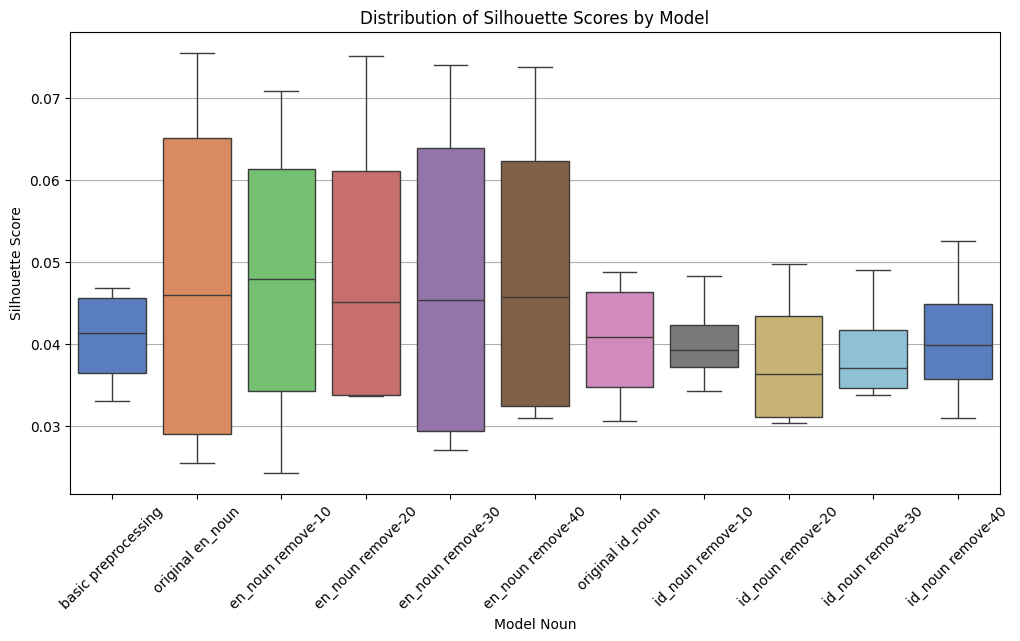

In [8]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='model_noun'
)
plt.title("Distribution of Silhouette Scores by Preprocessing Method")
plt.xlabel("Preprocessing Method")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Line plot to visualize the trend of silhouette scores over cluster range

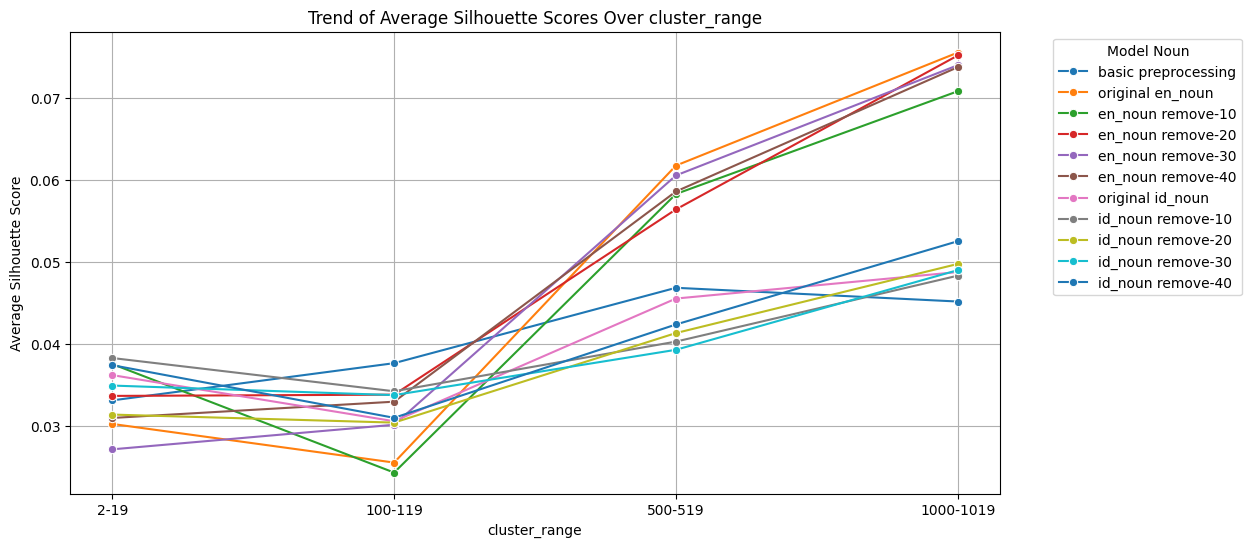

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


### Facet grid plot to visualize the distribution of best silhoutte scores over cluster range for each preprocessing method

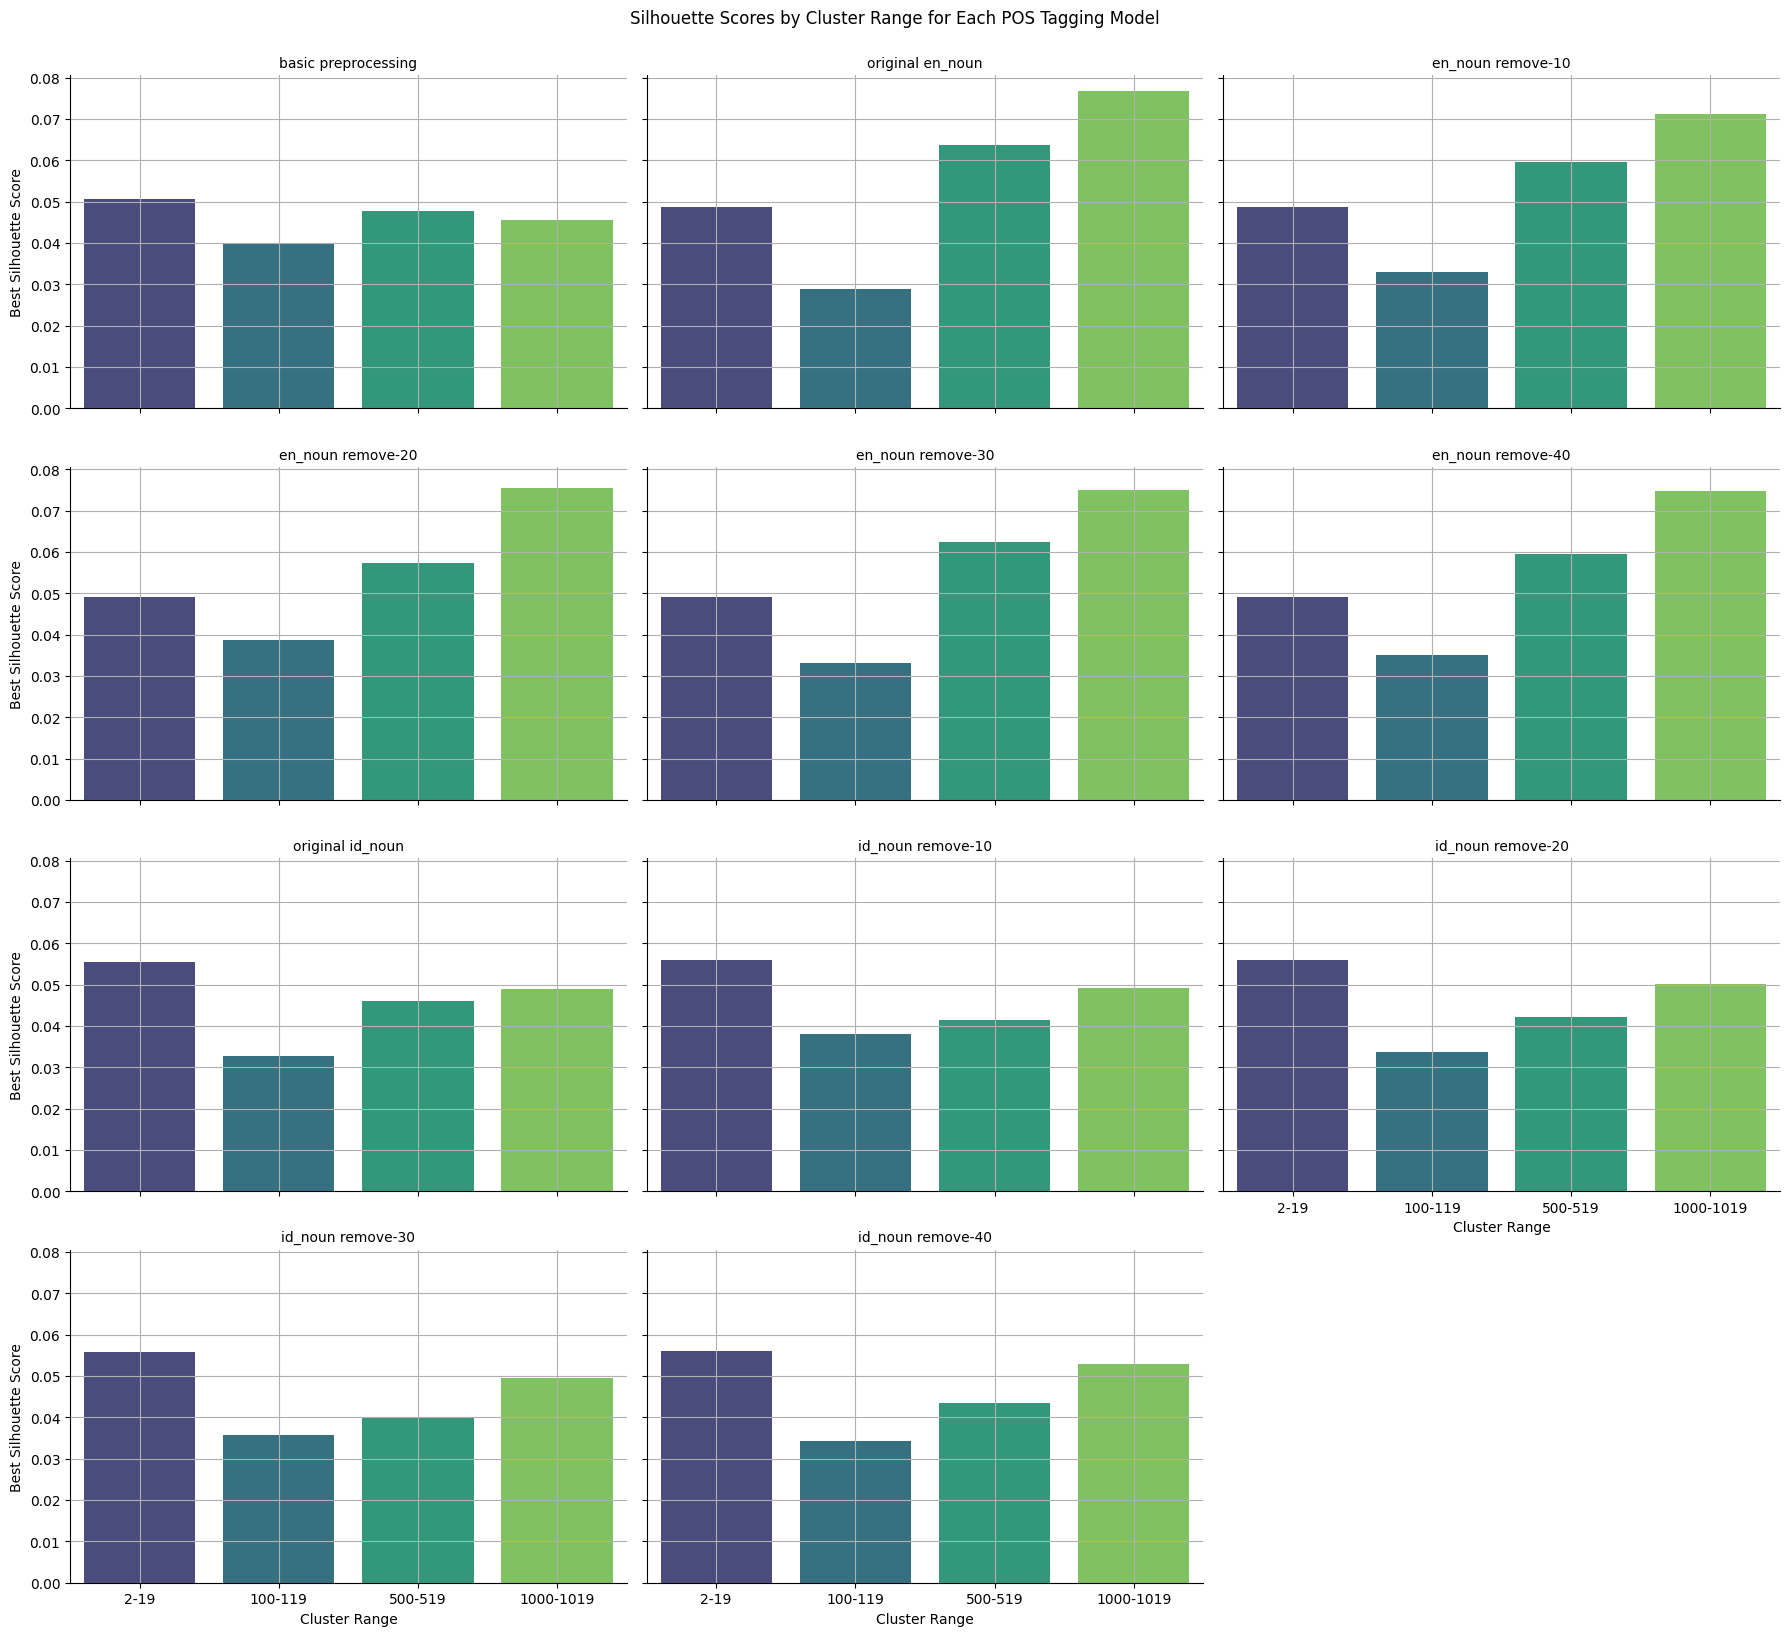

In [10]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Best Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

### Facet grid plot to visualize the distribution of average silhoutte scores over cluster range for each preprocessing method

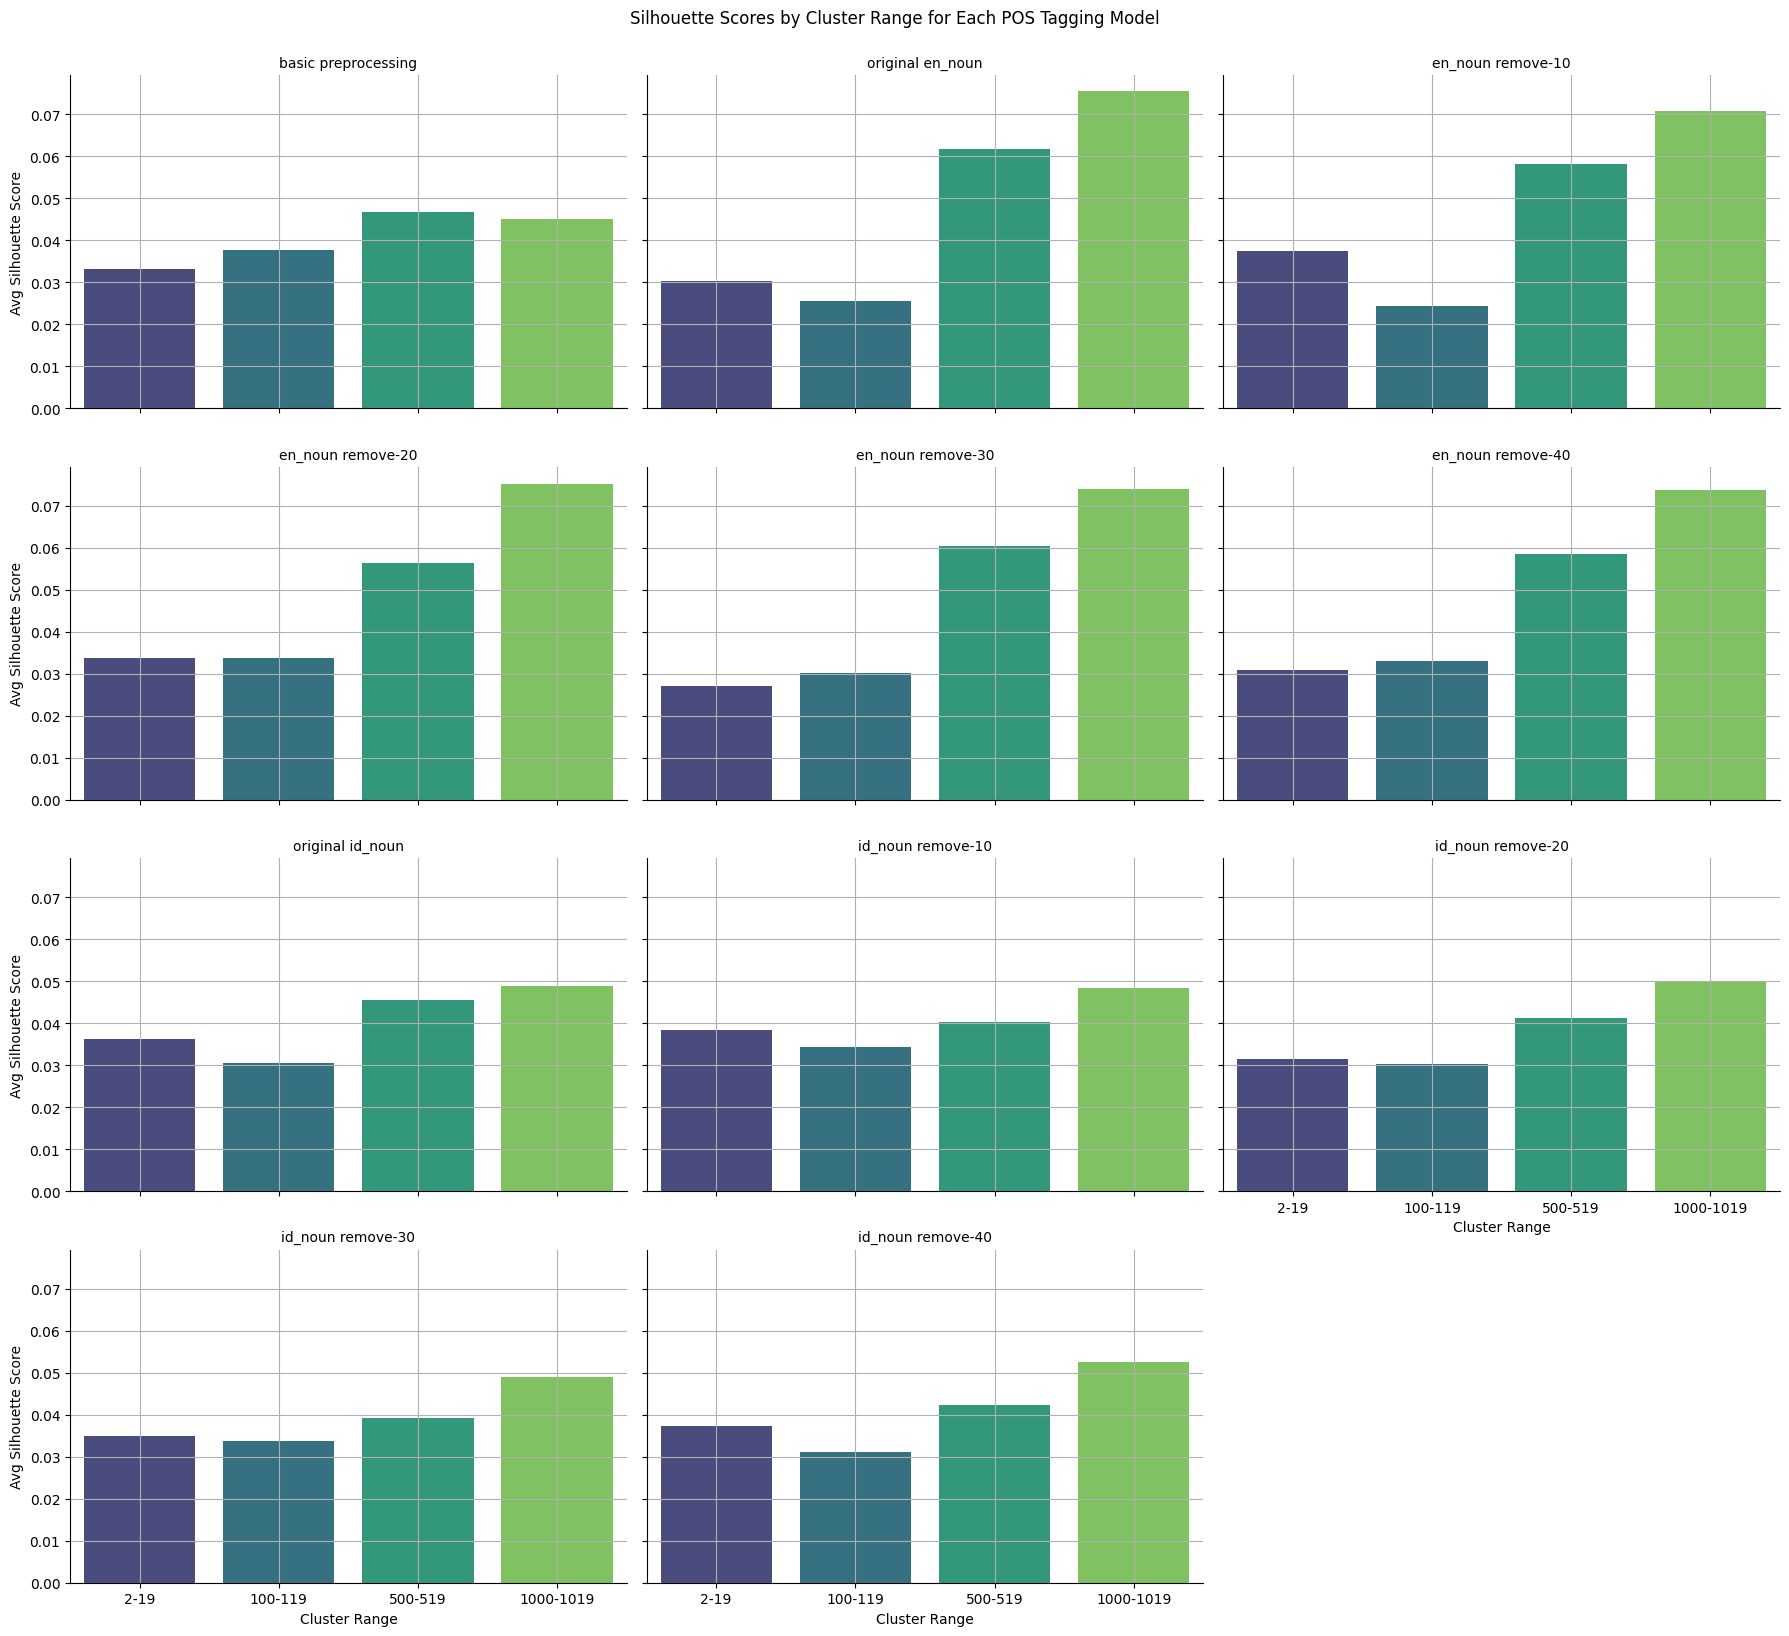

In [11]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Average Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# Choose the Best Preprocessing Method and Continue Analysis by Clustering

In [26]:
def show_cluster(column_name, cluster_number):
    pd.set_option('display.max_colwidth', None)

    # Show some product examples from each cluster
    for n_clusters in range(cluster_number):
        print(f"\nExamples of products in Cluster {n_clusters}:")
        print(df[df[column_name] == n_clusters][['name']].head(5))

    # Reset display option
    pd.reset_option('display.max_colwidth')

In [36]:
from wordcloud import WordCloud

def show_wordclouds(column_name, cluster_number):
    for n_clusters in range(cluster_number):
        # get the data in the cluster
        cluster_data = df[df[column_name] == n_clusters]['name'].dropna().tolist()
        text = " ".join(cluster_data)  # join all the text in the cluster

        # Generate WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Show WordCloud
        plt.figure(figsize=(6, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {n_clusters}", fontsize=16)
        plt.show()

## Find Optimum K Cluster using Elbow Method

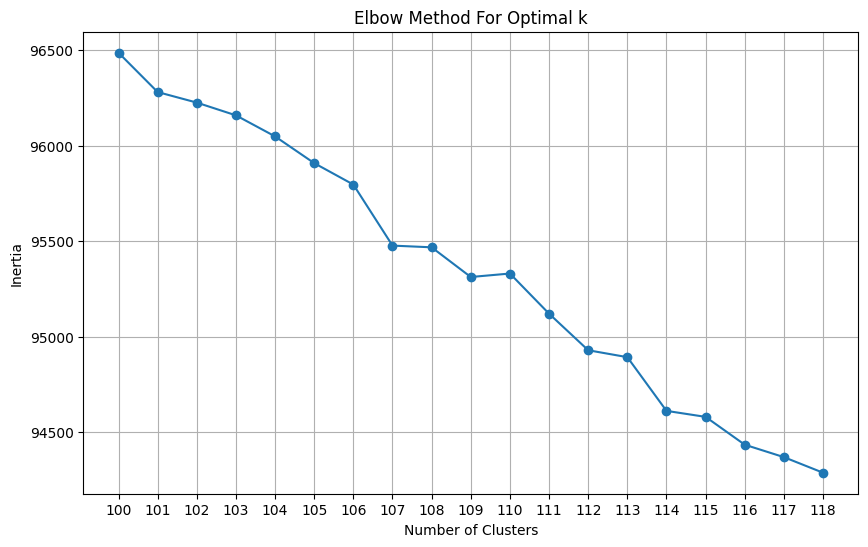

In [21]:
inertia_values = []
cluster_range = range(100, 119)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['original en_noun'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

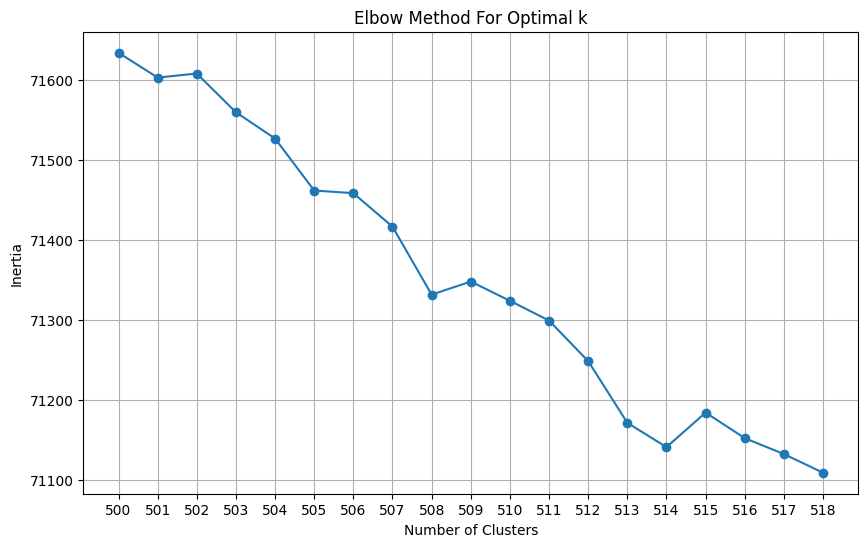

In [22]:
inertia_values = []
cluster_range = range(500, 519)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['original en_noun'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

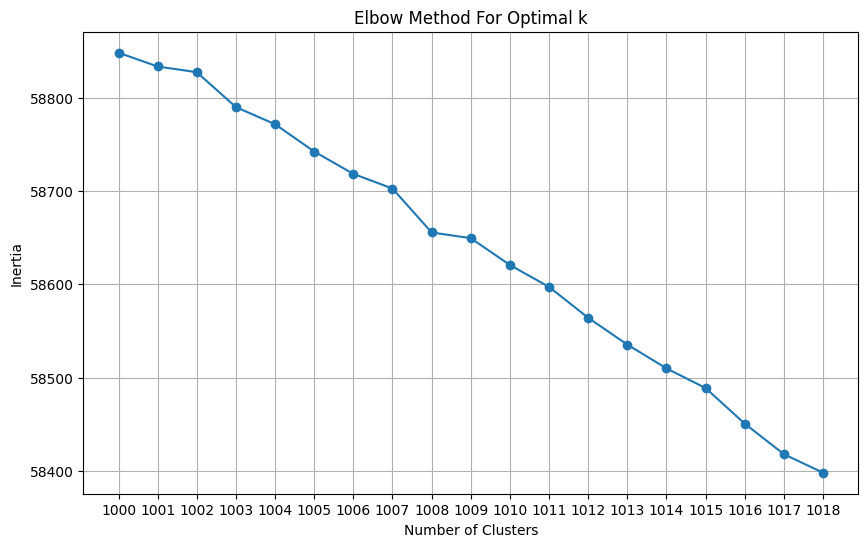

In [20]:
inertia_values = []
cluster_range = range(1000, 1019)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['original en_noun'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## Analysis Each Optimum Cluster

### Cluster 100

In [23]:
optimal_k = 110
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster100'] = kmeans.fit_predict(vectorizers['original en_noun'])

In [28]:
show_cluster('cluster100', 10)


Examples of products in Cluster 0:
                                                                      name
202   Topi Renang Pantai Selancar Pria Men Surfing Surf Hat 500 Popy Black
422                         Topi Ulang Tahun Birthday Hat Topi Ultah Pesta
453         Topi Peci Abdul Somad Kopiah Miki Hat Polos Harga Grosir MURAH
1285                               Topi Kalibre Baseball Hat art 991493474
1326             Topi Kupluk Bayi Rajut Topi Kupluk Anak Rajut Knitted Hat

Examples of products in Cluster 1:
                                                                      name
4    Buku Ilmu Sosial Budaya Dasar Perspektif Baru Membangun Kesadaran ani
62        BUKU PSIKOLOGI MODERN DALAM PERSPEKTIF AGAMA BUDDHA S DHAMMASIRI
295                                   ASUHAN KEPERAWATAN NEONATUS DAN ANAK
306          Buku Sosial - Pengawasan Industri dalam Pencemaran Lingkungan
351      Buku Belajar Mengenal Lingkungan Hidup Berwawasan IPTEK Dan IMTAK

Examples of products in Clu

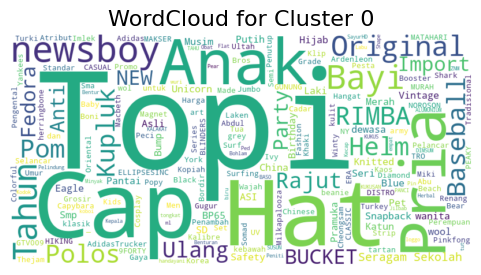

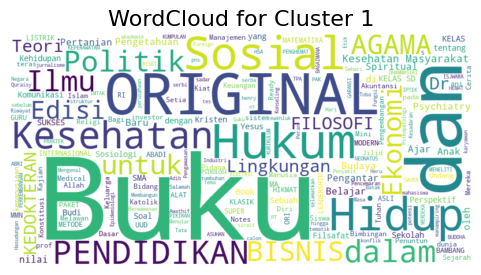

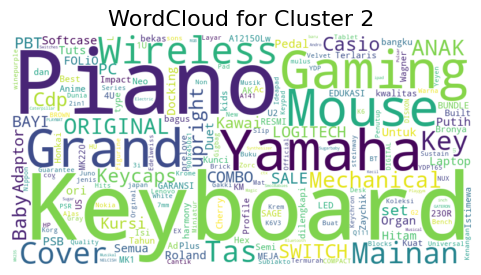

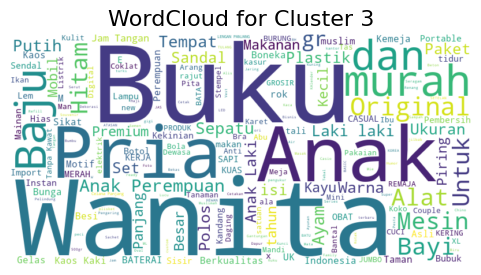

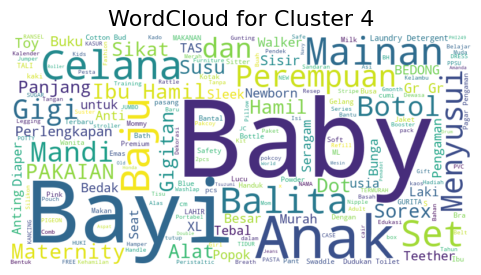

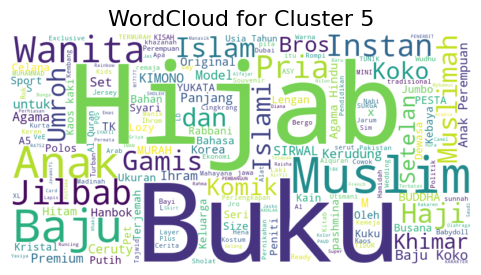

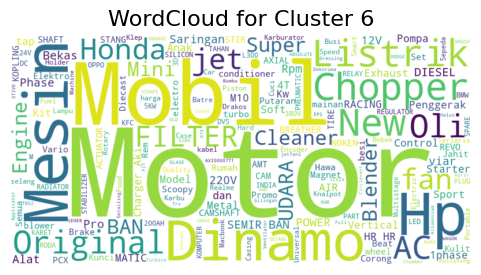

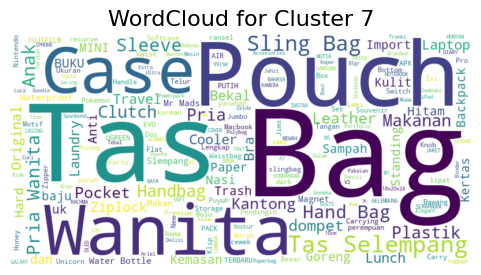

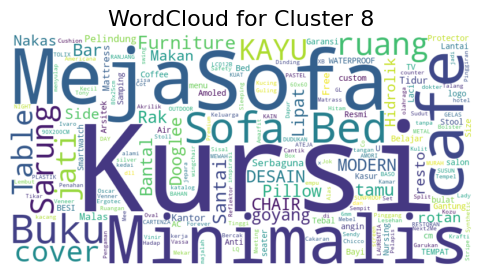

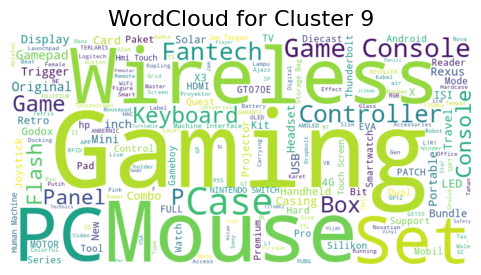

In [37]:
show_wordclouds('cluster100', 10)

### Cluster 500

In [30]:
optimal_k = 508
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster500'] = kmeans.fit_predict(vectorizers['original en_noun'])

In [31]:
show_cluster('cluster500', 10)


Examples of products in Cluster 0:
                                                                      name
202   Topi Renang Pantai Selancar Pria Men Surfing Surf Hat 500 Popy Black
422                         Topi Ulang Tahun Birthday Hat Topi Ultah Pesta
453         Topi Peci Abdul Somad Kopiah Miki Hat Polos Harga Grosir MURAH
1285                               Topi Kalibre Baseball Hat art 991493474
1630        topi pria & wanita kupluk Katun rajut beanie hat polos Abu Tua

Examples of products in Cluster 1:
                                                                        name
295                                     ASUHAN KEPERAWATAN NEONATUS DAN ANAK
830   BUKU Epidemiologi Penyakit Menular: Pengantar Bagi mahasiswa Kesehatan
1115                        Buku Pengantar Sosiologi Kesehatan dan Kesehatan
1158                          Buku Psikopatologi dalam Kehidupan Sehari-Hari
1873                       Buku Pendidikan Etik(a)et Dalam Keluarga ORIGINAL

Examples of pro

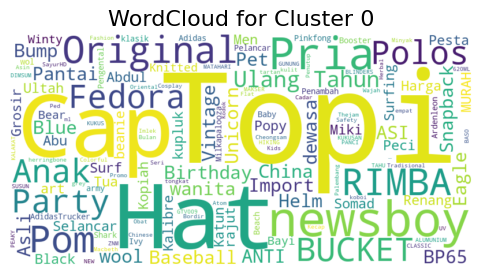

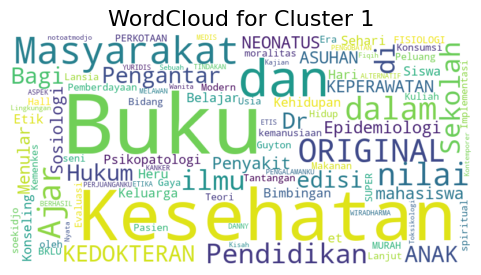

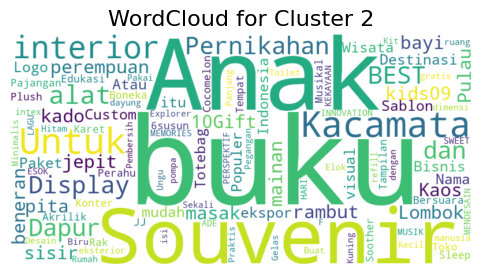

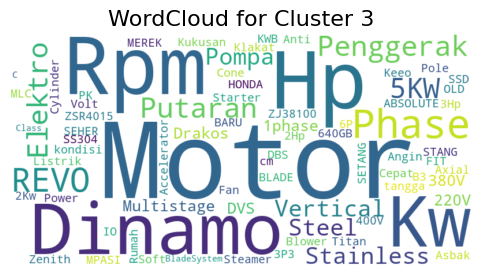

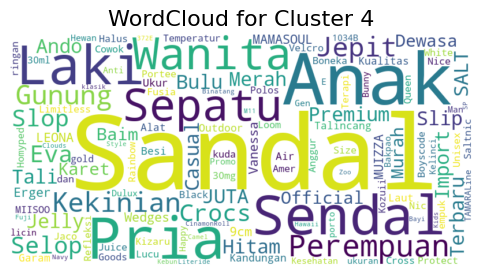

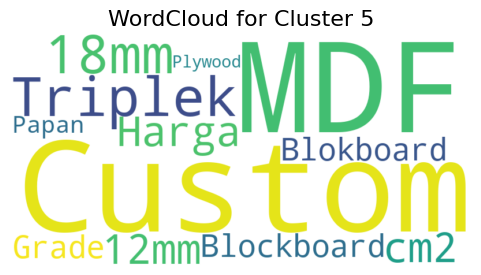

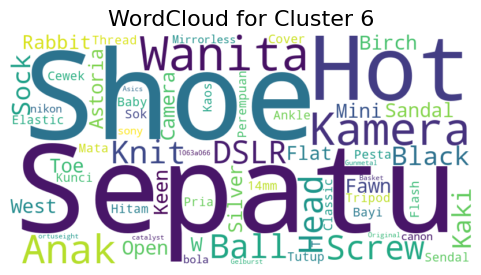

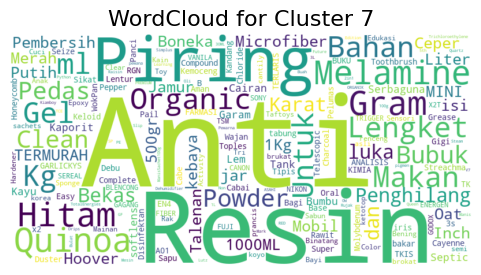

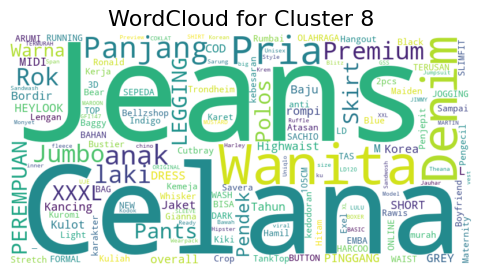

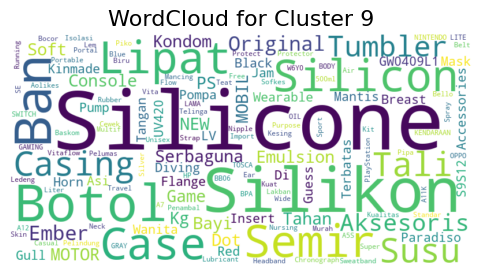

In [38]:
show_wordclouds('cluster500', 10)

### Cluster 1000

In [33]:
optimal_k = 1008
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster1000'] = kmeans.fit_predict(vectorizers['original en_noun'])

In [34]:
show_cluster('cluster1000', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
3537                                                 Topi newsboy cap kulit
5915     Minyak NEW ZNM cap 4 empat tongkat Original Asli Obat Herbal 50 ml
7632                 SayurHD Kecap Asin Atom Cap Bulan Palembang Asli 620ML

Examples of products in Cluster 1:
                                                                        name
830   BUKU Epidemiologi Penyakit Menular: Pengantar Bagi mahasiswa Kesehatan
1115                        Buku Pengantar Sosiologi Kesehatan dan Kesehatan
1158                          Buku Psikopatologi dalam Kehidupan Sehari-Hari
2306  Buku Pemberdayaan Masyarakat di Bidang Kesehatan: Teori & Implementasi
2349     Buku Hukum Kesehatan Masyarakat Peluang dan Tantangan di Era Modern

Examples of products in Cluster 2:
                                                  

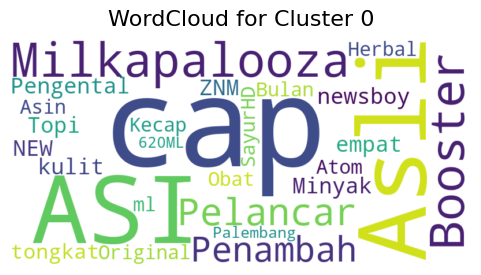

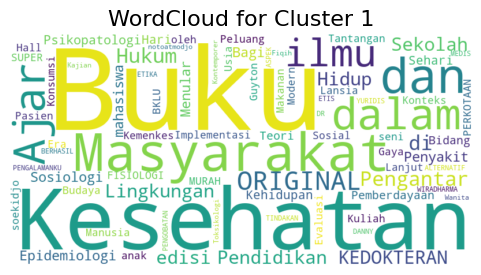

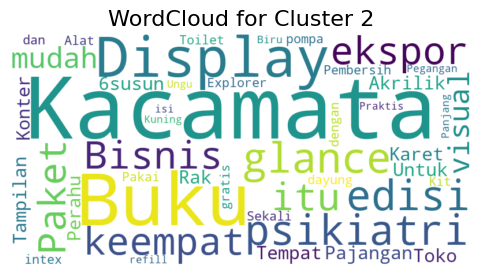

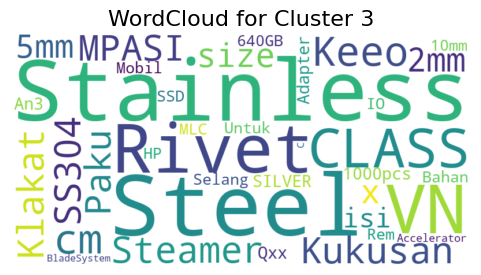

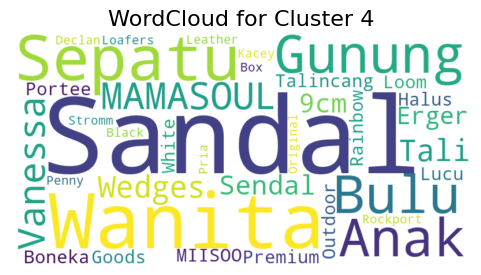

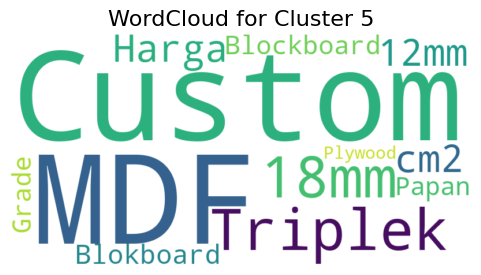

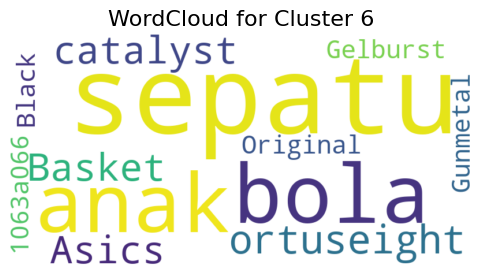

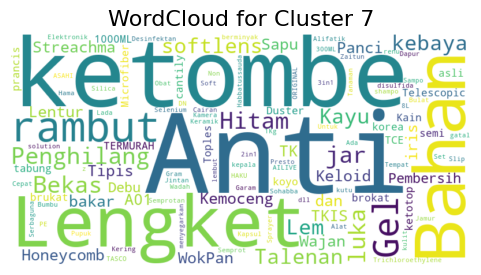

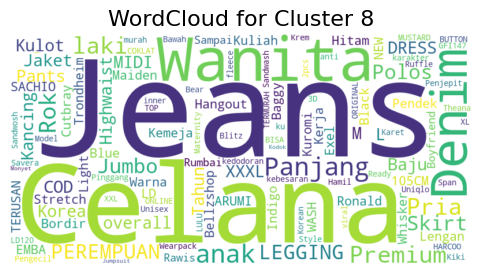

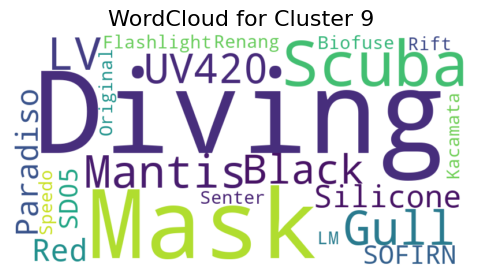

In [39]:
show_wordclouds('cluster1000', 10)